# Learning rate test

In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [2]:
DATA_DIR = os.path.abspath(os.path.join("data", "lrtest"))
%mkdir -p $DATA_DIR

# Test helpers

In [3]:
class SaveHistory(keras.callbacks.Callback):
    def __init__(self):
        self.batches = dict()
        self.epochs = dict()
        
    def _update(self, hist, logs={}):
        for k in self.params['metrics']:
            if k in logs:
                hist.setdefault(k, []).append(logs[k].item())
    
    def on_batch_end(self, batch, logs={}):
        self._update(self.batches, logs)
    
    def on_epoch_end(self, epoch, logs={}):
        self._update(self.epochs, logs)

In [4]:
class AssignAndSetVal(object):
    LABELS = ['assign', 'setval']
    
    @classmethod
    def set1(cls, model, value):
        model.optimizer.lr = value
    
    @classmethod
    def set2(cls, model, value):
        model.optimizer.lr.set_value(value)

In [5]:
class BothAssign(object):
    LABELS = ['assign-1', 'assign-2']
    
    @classmethod
    def set1(cls, model, value):
        model.optimizer.lr = value
    
    set2 = set1

In [6]:
class BothSetVal(object):
    LABELS = ['setval-1', 'setval-2']
    
    @classmethod
    def set1(cls, model, value):
        model.optimizer.lr.set_value(value)
    
    set2 = set1

In [17]:
class LRTester(object):
    def __init__(self, model_factory, setter=AssignAndSetVal, optimizer=None,
                 datadir=DATA_DIR, shuffle=False, verbose=1):
        self.setter = setter
        self.optimizer = optimizer
        self.factory = model_factory
        self.datadir = datadir
        self.shuffle = shuffle
        self.verbose = verbose
        self.models = []
        self.histories = []
        self.modelsdir = os.path.join(datadir, 'models')
        if not os.path.exists(self.modelsdir):
            os.makedirs(self.modelsdir)
            
    def getmodel(self):
        kwargs = dict()
        if self.optimizer is not None:
            kwargs["optimizer"] = self.optimizer
        return self.factory.getmodel(**kwargs)
        
    def savefile(self, suffix):
        return "%s/%s_%s.h5" % (self.modelsdir, self.factory.NAME, suffix)
        
    def save_weights(self):
        for model, label in zip(self.models, self.setter.LABELS):
            model.save_weights(self.savefile(label + '_wgts'))
        
    def load_weights(self):
        self.models = [self.getmodel(), self.getmodel()]
        for model, label in zip(self.models, self.setter.LABELS):
            model.load_weights(self.savefile(label + '_wgts'))
        
    def save_hist(self):
        for hist, label in zip(self.histories, self.setter.LABELS):
            with open(self.savefile(label + '_hist'), 'w') as f:
                pickle.dump(hist, f)
        
    def load_hist(self):
        self.histories = []
        for label in self.setter.LABELS:
            with open(self.savefile(label + '_hist')) as f:
                self.histories.append(pickle.load(f))
        
    def save_state(self):
        self.save_weights()
        self.save_hist()
        
    def load_state(self):
        self.load_weights()
        self.load_hist()
        
    def plotrow(self, axes, data1, data2, metric):
        ax_data, ax_delta = axes
        xs1, xs2 = data1[metric], data2[metric]
        label1, label2 = self.setter.LABELS
        
        ax_data.set_ylabel(metric)
        ax_data.plot(xs1, label=label1, color='blue', alpha=0.6)
        ax_data.plot(xs2, label=label2, color='red', alpha=0.6)
        ax_data.legend()
        
        ax_delta.set_ylabel(metric + ' delta')
        deltas = np.array(xs1) - np.array(xs2)
        ax_delta.plot(deltas, color='green')
        
    def _get_fig_title(self, figname, hist1, hist2):
        
        def merge_if_equal(optname, v1, v2):
            if v1 == v2:
                fmt = "{optname}={v1};"
            else:
                fmt = "{optname}1={v1}; {optname}2={v2}"
            return fmt.format(optname=optname, v1=v1, v2=v2)
        
        opt1 = hist1.optimizer.__class__.__name__
        opt2 = hist2.optimizer.__class__.__name__
        
        title = "{} {}\n".format(self.factory.NAME, figname)
        opt = merge_if_equal("opt", opt1, opt2)
        steps = merge_if_equal("steps", hist1.steps, hist2.steps)
        return title + opt + ' ' + steps

        
    def makefig(self, name):
        hist1, hist2 = self.histories
        data1 = getattr(hist1, name)
        data2 = getattr(hist2, name)
        
        nrows = len(data1)
        lastrow = nrows - 1
        thisrow = -1
        
        fig, axes = plt.subplots(nrows, 2, figsize=(12,2*nrows), sharex=True)
        fig.suptitle(self._get_fig_title(name, hist1, hist2))
        
        for metric in hist1.params['metrics']:
            if metric in data1:
                thisrow += 1
                self.plotrow(axes[thisrow], data1, data2, metric)
                if thisrow == lastrow:
                    axes[thisrow][0].set_xlabel(name)
                    axes[thisrow][1].set_xlabel(name)
            
        plt.show()
                
    def makefigs(self):
        self.makefig('batches')
        self.makefig('epochs')
        
    def _run_steps(self, model, hist, steps, setfn):
        hist.steps = steps
        hist.optimizer = model.optimizer
        
        for lr, nb_epoch in steps:
            if lr is not None:
                setfn(model, lr)
            
            train, test = self.factory.getbatches(shuffle=self.shuffle)
            self.factory.fitmodel(model, train, test, nb_epoch, callbacks=[hist], verbose=self.verbose)
        
    def run(self, steps=None, steps1=None, steps2=None):
        if steps is not None:
            steps1 = steps2 = steps
        elif steps1 is None or steps2 is None:
            raise ValueError("Must specify either steps or both steps1 and steps2")
        
        # Normalize each step to an (lr, nb_epoch) tuple, with nb_epoch defaulting to one.
        steps1 = [step if isinstance(step, tuple) else (step, 1) for step in steps1]
        steps2 = [step if isinstance(step, tuple) else (step, 1) for step in steps2]
        
        model1 = self.getmodel()
        model2 = self.getmodel()
        model2.set_weights(model1.get_weights())
        self.models = [model1, model2]
        
        hist1 = SaveHistory()
        hist2 = SaveHistory()
        self.histories = [hist1, hist2]
                                
        self._run_steps(model1, hist1, steps1, self.setter.set1)
        self._run_steps(model2, hist2, steps2, self.setter.set2)

In [8]:
def runtests(model_factory):
    for opt in [Adam, SGD]:
        for setter in [AssignAndSetVal, BothSetVal, BothAssign]:
            t = LRTester(model_factory, setter=setter, optimizer=opt, verbose=0)
            t.run(steps=[(None, 1), (0.1, 1), (0.01, 1)])
            t.makefig('batches')

# MNIST

Test various models from `mnist.ipynb`.

## MNIST Setup

In [9]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [10]:
X_test = np.expand_dims(X_test,1)
X_train = np.expand_dims(X_train,1)
y_train = onehot(y_train)
y_test = onehot(y_test)

In [11]:
def norm_input(x):
    mean_px = X_train.mean().astype(np.float32)
    std_px = X_train.std().astype(np.float32)
    return (x-mean_px)/std_px

## MNIST Linear Model

In [18]:
class MNIST_Linear(object):
    NAME = 'MNIST_Linear'
    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        model = Sequential([
            Lambda(norm_input, input_shape=(1,28,28)),
            Flatten(),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def getbatches(cls, batch_size=64, shuffle=False,
                   x=X_train, y=y_train, x_val=X_test, y_val=y_test):
        gen = image.ImageDataGenerator()
        batches = gen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        test_batches = gen.flow(x_val, y_val, batch_size=batch_size, shuffle=shuffle)
        return batches, test_batches
    
    @classmethod
    def fitmodel(cls, model, batches, test_batches, nb_epoch, callbacks=None, verbose=1):
        model.fit_generator(batches, batches.N, nb_epoch=nb_epoch, callbacks=callbacks,
                            validation_data=test_batches, nb_val_samples=test_batches.N,
                            verbose=verbose)

Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.4333 - acc: 0.8726 - val_loss: 0.3210 - val_acc: 0.9059
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.3100 - acc: 0.9122 - val_loss: 0.3082 - val_acc: 0.9111
Epoch 1/4
60000/60000 [==============================] - 24s - loss: 0.2959 - acc: 0.9172 - val_loss: 0.3052 - val_acc: 0.9124
Epoch 2/4
60000/60000 [==============================] - 24s - loss: 0.2884 - acc: 0.9197 - val_loss: 0.3041 - val_acc: 0.9136
Epoch 3/4
60000/60000 [==============================] - 24s - loss: 0.2833 - acc: 0.9212 - val_loss: 0.3033 - val_acc: 0.9138
Epoch 4/4
60000/60000 [==============================] - 30s - loss: 0.2796 - acc: 0.9226 - val_loss: 0.3031 - val_acc: 0.9147
Epoch 1/1
60000/60000 [==============================] - 32s - loss: 0.4333 - acc: 0.8726 - val_loss: 0.3210 - val_acc: 0.9059
Epoch 1/1
60000/60000 [==============================] - 25s - loss: 6.8714 - acc: 0.5677 - val_loss: 6.5073 - 

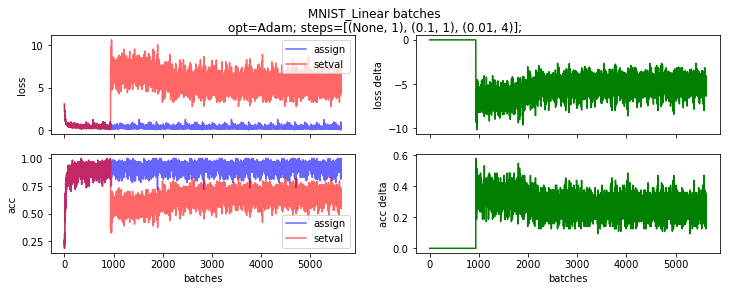

In [455]:
t = LRTester(MNIST_Linear, setter=AssignAndSetVal, optimizer=Adam)
t.run(steps=[(None, 1), (0.1, 1), (0.01, 4)])
t.makefig('batches')

In [456]:
t.save_state()

Epoch 1/1
60000/60000 [==============================] - 23s - loss: 0.4359 - acc: 0.8706 - val_loss: 0.3199 - val_acc: 0.9073
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.3110 - acc: 0.9113 - val_loss: 0.3083 - val_acc: 0.9110
Epoch 1/1
60000/60000 [==============================] - 25s - loss: 0.2966 - acc: 0.9167 - val_loss: 0.3055 - val_acc: 0.9129
Epoch 1/1
60000/60000 [==============================] - 25s - loss: 0.4359 - acc: 0.8706 - val_loss: 0.3199 - val_acc: 0.9073
Epoch 1/1
60000/60000 [==============================] - 26s - loss: 4.7737 - acc: 0.6910 - val_loss: 4.6670 - val_acc: 0.7028
Epoch 1/1
60000/60000 [==============================] - 34s - loss: 4.2944 - acc: 0.7280 - val_loss: 4.1933 - val_acc: 0.7346


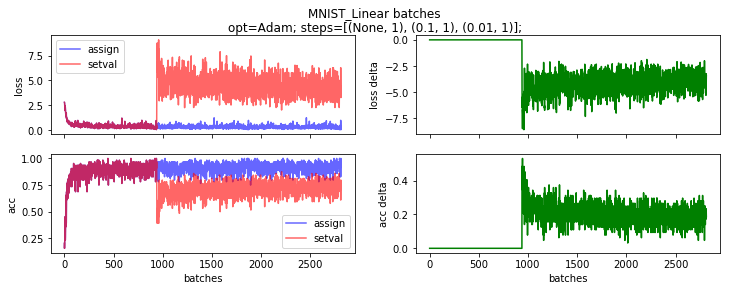

Epoch 1/1
60000/60000 [==============================] - 31s - loss: 0.4367 - acc: 0.8693 - val_loss: 0.3218 - val_acc: 0.9043
Epoch 1/1
60000/60000 [==============================] - 33s - loss: 5.7198 - acc: 0.6361 - val_loss: 5.4093 - val_acc: 0.6606
Epoch 1/1
60000/60000 [==============================] - 32s - loss: 5.3876 - acc: 0.6621 - val_loss: 5.2668 - val_acc: 0.6698
Epoch 1/1
60000/60000 [==============================] - 29s - loss: 0.4367 - acc: 0.8693 - val_loss: 0.3218 - val_acc: 0.9043
Epoch 1/1
60000/60000 [==============================] - 22s - loss: 5.7198 - acc: 0.6361 - val_loss: 5.4093 - val_acc: 0.6606.63 - ETA: 1s - l - ETA: 0s - loss: 5.7354 -  - ETA: 0s - los
Epoch 1/1
60000/60000 [==============================] - 32s - loss: 5.3876 - acc: 0.6621 - val_loss: 5.2668 - val_acc: 0.6698


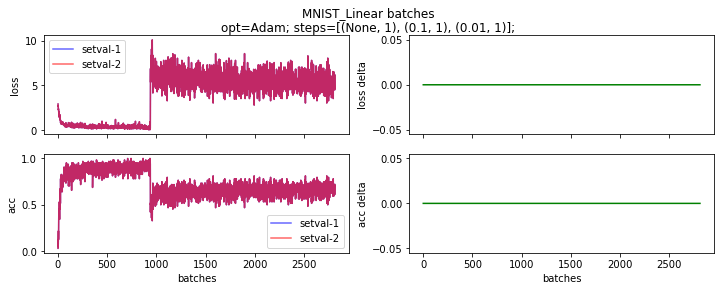

Epoch 1/1
60000/60000 [==============================] - 34s - loss: 0.4336 - acc: 0.8712 - val_loss: 0.3202 - val_acc: 0.9075
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 0.3115 - acc: 0.9111 - val_loss: 0.3076 - val_acc: 0.9100
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 0.2967 - acc: 0.9162 - val_loss: 0.3043 - val_acc: 0.9115
Epoch 1/1
60000/60000 [==============================] - 40s - loss: 0.4336 - acc: 0.8712 - val_loss: 0.3202 - val_acc: 0.9075
Epoch 1/1
60000/60000 [==============================] - 38s - loss: 0.3115 - acc: 0.9111 - val_loss: 0.3076 - val_acc: 0.9100
Epoch 1/1
60000/60000 [==============================] - 36s - loss: 0.2967 - acc: 0.9162 - val_loss: 0.3043 - val_acc: 0.9115


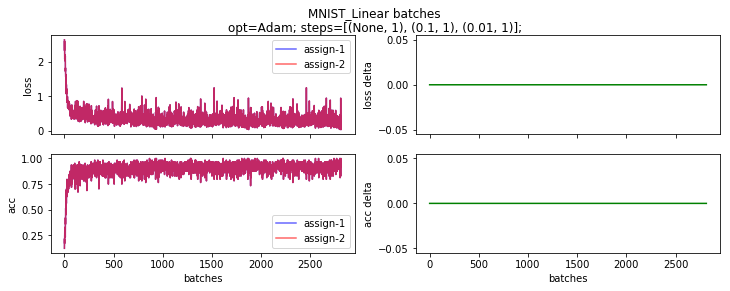

Epoch 1/1
60000/60000 [==============================] - 41s - loss: 0.5069 - acc: 0.8510 - val_loss: 0.3448 - val_acc: 0.90110.5072 - acc: 0.85
Epoch 1/1
60000/60000 [==============================] - 32s - loss: 0.3425 - acc: 0.9017 - val_loss: 0.3132 - val_acc: 0.9102
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 0.3184 - acc: 0.9088 - val_loss: 0.3004 - val_acc: 0.9135
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 0.5069 - acc: 0.8510 - val_loss: 0.3448 - val_acc: 0.9011
Epoch 1/1
60000/60000 [==============================] - 40s - loss: 0.3429 - acc: 0.9024 - val_loss: 0.3415 - val_acc: 0.9010
Epoch 1/1
60000/60000 [==============================] - 40s - loss: 0.2857 - acc: 0.9208 - val_loss: 0.2807 - val_acc: 0.9207


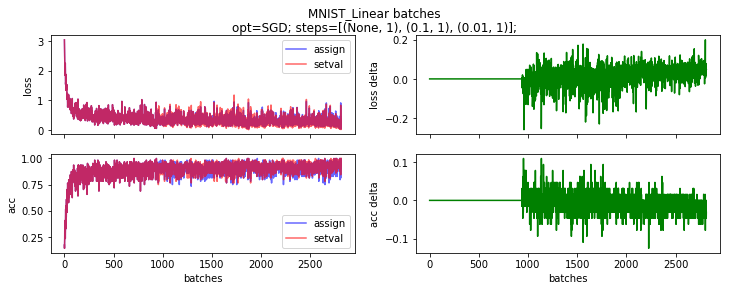

Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.5187 - acc: 0.8493 - val_loss: 0.3436 - val_acc: 0.9004
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 0.3429 - acc: 0.9022 - val_loss: 0.3418 - val_acc: 0.9033
Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.2861 - acc: 0.9209 - val_loss: 0.2804 - val_acc: 0.9200.920 - ETA: 0s - loss: 0.
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 0.5187 - acc: 0.8493 - val_loss: 0.3436 - val_acc: 0.9004
Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.3429 - acc: 0.9022 - val_loss: 0.3418 - val_acc: 0.9033
Epoch 1/1
60000/60000 [==============================] - 38s - loss: 0.2861 - acc: 0.9209 - val_loss: 0.2804 - val_acc: 0.9200


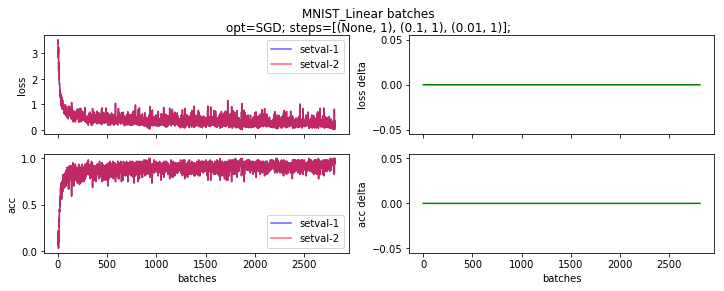

Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.5028 - acc: 0.8519 - val_loss: 0.3484 - val_acc: 0.8997
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 0.3413 - acc: 0.9019 - val_loss: 0.3158 - val_acc: 0.9079
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 0.3176 - acc: 0.9089 - val_loss: 0.3026 - val_acc: 0.9120
Epoch 1/1
60000/60000 [==============================] - 36s - loss: 0.5028 - acc: 0.8519 - val_loss: 0.3484 - val_acc: 0.8997
Epoch 1/1
60000/60000 [==============================] - 43s - loss: 0.3413 - acc: 0.9019 - val_loss: 0.3158 - val_acc: 0.9079
Epoch 1/1
60000/60000 [==============================] - 43s - loss: 0.3176 - acc: 0.9089 - val_loss: 0.3026 - val_acc: 0.9120


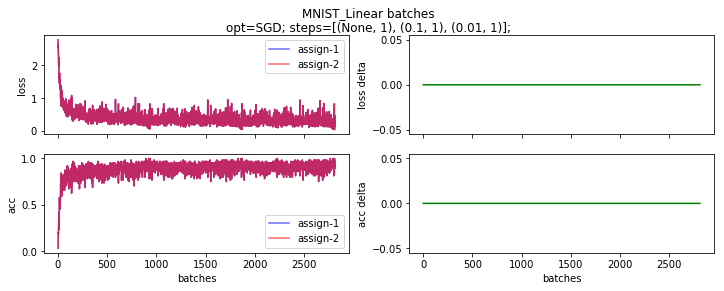

In [458]:
runtests(MNIST_Linear)

## MNIST batchnorm + dropout + data augmentation

In [19]:
class MNIST_CNN_BN_Dropout(object):
    NAME = 'MNIST_CNN_BN_Dropout'
    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        model = Sequential([
            Lambda(norm_input, input_shape=(1,28,28)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(32,3,3, activation='relu'),
            MaxPooling2D(),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            MaxPooling2D(),
            Flatten(),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def getbatches(cls, batch_size=64, shuffle=False,
                   x=X_train, y=y_train, x_val=X_test, y_val=y_test):
        gen = image.ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                                       height_shift_range=0.08, zoom_range=0.08)
        batches = gen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        test_batches = gen.flow(x_val, y_val, batch_size=batch_size, shuffle=shuffle)
        return batches, test_batches
    
    @classmethod
    def fitmodel(cls, model, batches, test_batches, nb_epoch, callbacks=None, verbose=1):
        model.fit_generator(batches, batches.N, nb_epoch=nb_epoch, callbacks=callbacks,
                            validation_data=test_batches, nb_val_samples=test_batches.N,
                            verbose=verbose)

/home/ma/opt/anaconda3/envs/fastai/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/ma/opt/anaconda3/envs/fastai/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/ma/opt/anaconda3/envs/fastai/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


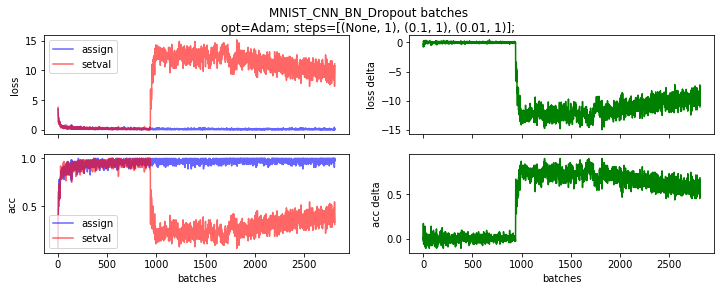

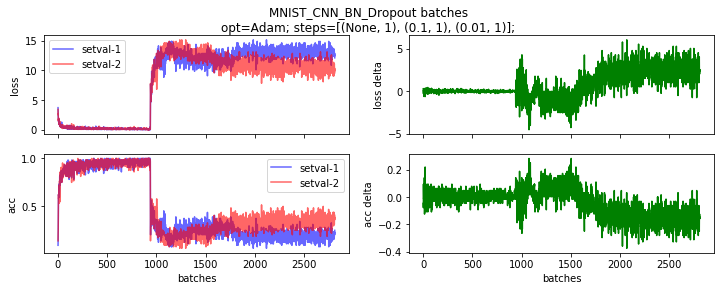

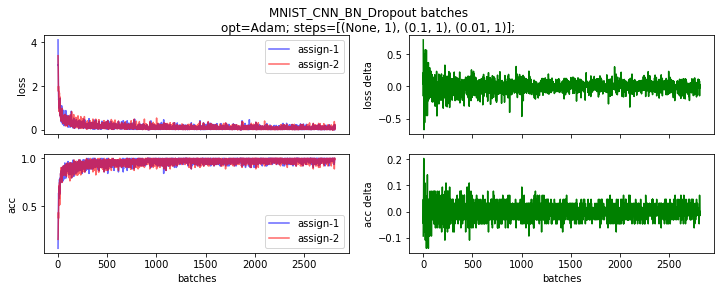

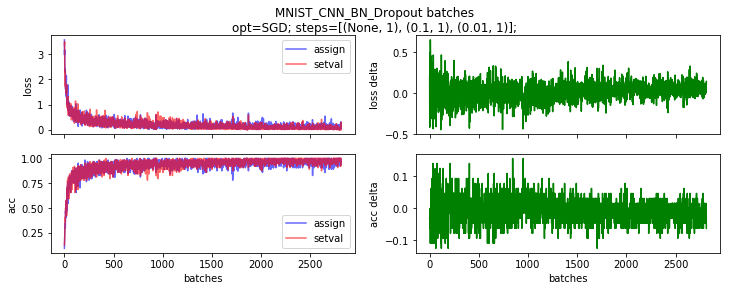

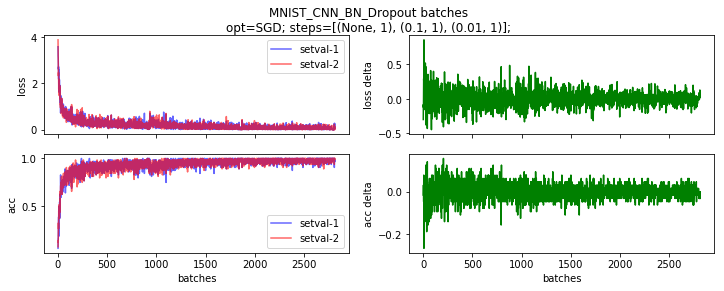

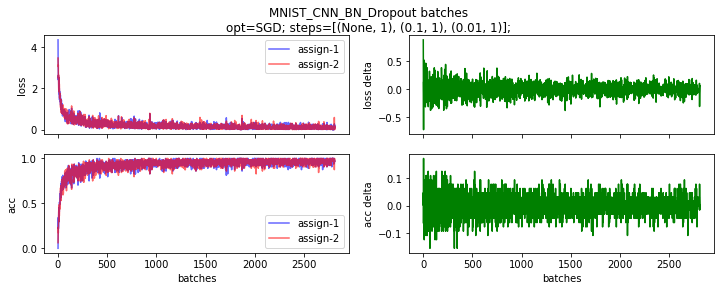

In [464]:
runtests(MNIST_CNN_BN_Dropout)

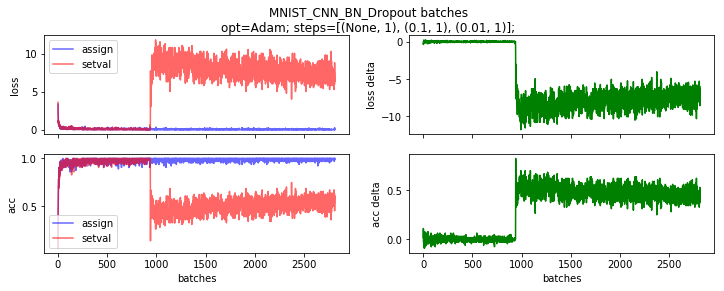

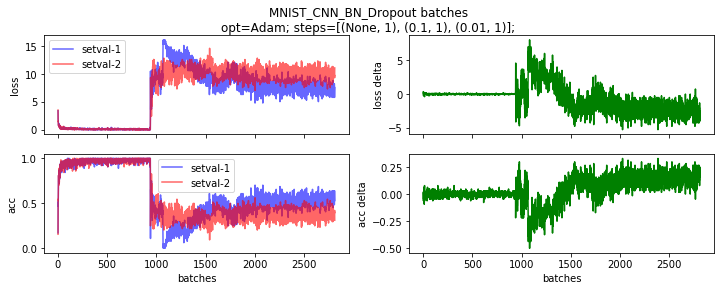

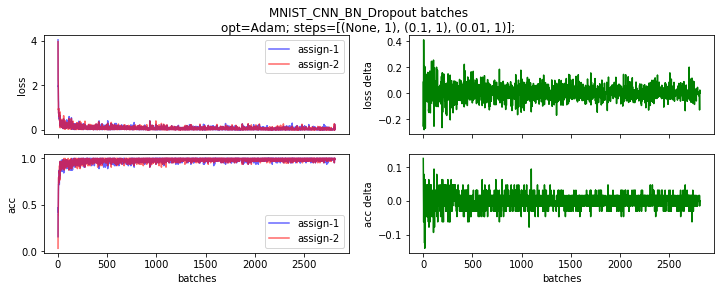

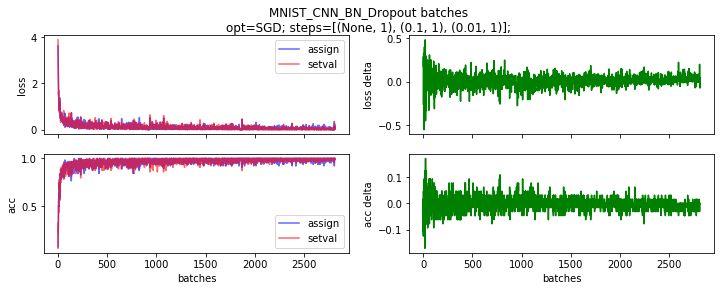

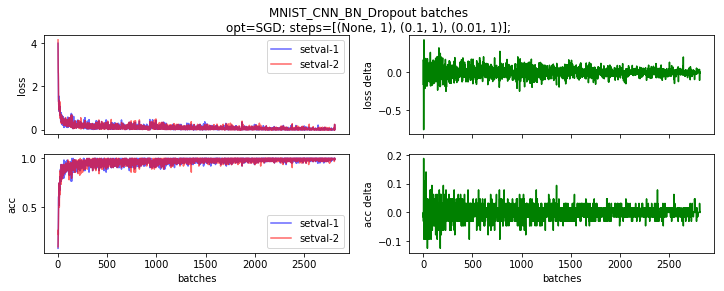

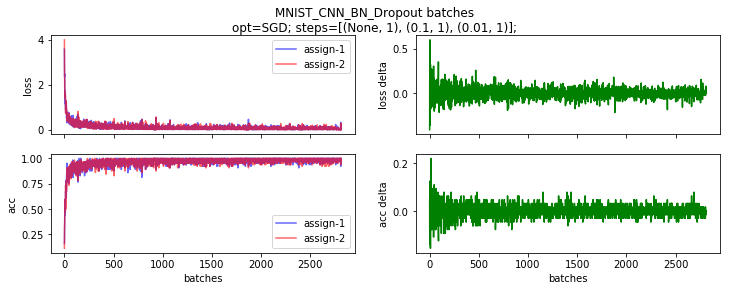

In [467]:
runtests(MNIST_CNN_BN_Dropout) # no data augmentation

Epoch 1/1
60000/60000 [==============================] - 629s - loss: 0.1200 - acc: 0.9649 - val_loss: 0.0447 - val_acc: 0.9851
Epoch 1/1
60000/60000 [==============================] - 694s - loss: 9.2205 - acc: 0.4249 - val_loss: 8.5664 - val_acc: 0.4680
Epoch 1/1
60000/60000 [==============================] - 713s - loss: 8.1341 - acc: 0.4949 - val_loss: 7.4209 - val_acc: 0.5394
Epoch 1/1
60000/60000 [==============================] - 682s - loss: 0.1192 - acc: 0.9650 - val_loss: 0.0416 - val_acc: 0.9865
Epoch 1/1
60000/60000 [==============================] - 658s - loss: 9.3005 - acc: 0.4201 - val_loss: 7.9239 - val_acc: 0.5082
Epoch 1/1
60000/60000 [==============================] - 653s - loss: 7.7793 - acc: 0.5170 - val_loss: 7.5418 - val_acc: 0.5319


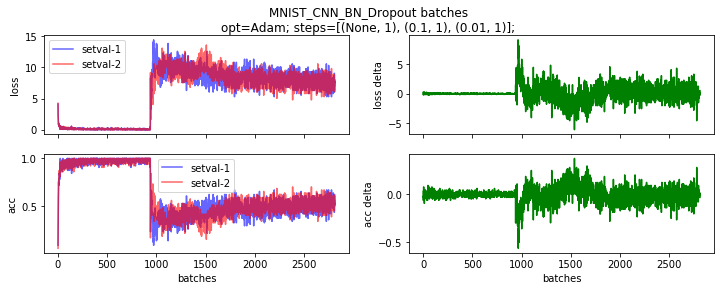

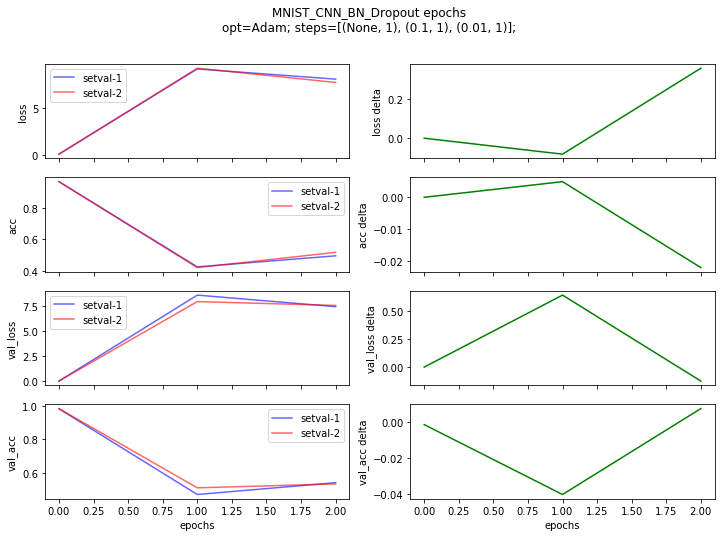

In [470]:
t = LRTester(MNIST_CNN_BN_Dropout, setter=BothSetVal)
t.run(steps=[(None, 1), (0.1, 1), (0.01, 1)])
t.makefigs()

# Dogs and Cats

## Dogs and Cats Setup

In [14]:
dogscats_path = os.path.join(DATA_DIR, 'dogscats')
dogscats_train_path = os.path.join(dogscats_path, 'sample', 'train')
dogscats_valid_path = os.path.join(dogscats_path, 'sample', 'valid')

In [502]:
dogscats_zip = get_file('dogscats.zip', 'http://files.fast.ai/data/dogscats.zip',
                        cache_subdir=DATA_DIR, md5_hash='aef22ec7d472dd60e8ee79eecc19f131')
!unzip -q -d $DATA_DIR $dogscats_zip

## Dogs and Cats Vgg16

In [20]:
class DogsCats_Vgg16(object):
    NAME = 'DogsCats_Vgg16'
    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        vgg = Vgg16()
        vgg.model.compile(optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        batches, _ = cls.getbatches()
        vgg.finetune(batches)
        return vgg.model
    
    @classmethod
    def getbatches(cls, **kwargs):
        gen = image.ImageDataGenerator()
        kwargs['target_size'] = (224,224)
        kwargs['class_mode'] = 'categorical'
        batches = gen.flow_from_directory(dogscats_train_path, **kwargs)
        test_batches = gen.flow_from_directory(dogscats_valid_path, **kwargs)
        return batches, test_batches
    
    @classmethod
    def fitmodel(cls, model, batches, test_batches, nb_epoch, callbacks=None, verbose=1):
        model.fit_generator(batches, batches.N, nb_epoch=nb_epoch, callbacks=callbacks,
                            validation_data=test_batches, nb_val_samples=test_batches.N,
                            verbose=verbose)

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Epoch 1/1
16/16 [==============================] - 30s - loss: 1.9608 - acc: 0.3125 - val_loss: 0.7651 - val_acc: 0.6250
Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Epoch 1/1
16/16 [==============================] - 29s - loss: 0.8527 - acc: 0.6250 - val_loss: 0.7962 - val_acc: 0.6250
Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Epoch 1/1
16/16 [==============================] - 31s - loss: 0.5943 - acc: 0.7500 - val_loss: 0.8893 - val_acc: 0.6250
Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Epoch 1/1
16/16 [==============================] - 31s - loss: 1.2174 - acc: 0.5000 - val_loss: 0.7603 - val_acc: 0.7500
Found 16 images belonging to 2 classes.
Fo

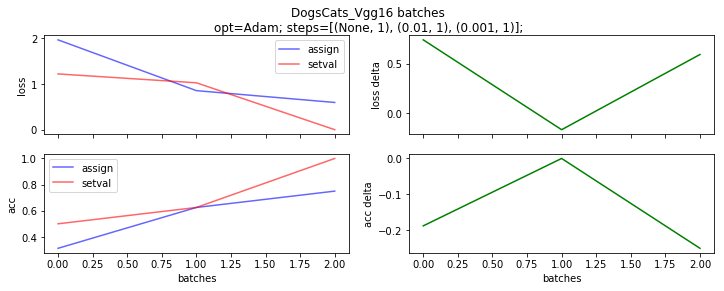

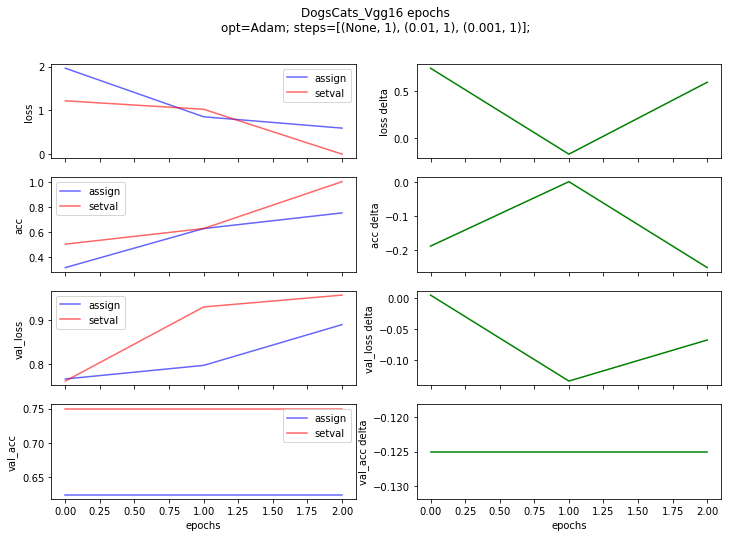

In [21]:
t = LRTester(DogsCats_Vgg16)
t.run(steps=[None, 0.01, 0.001])
t.makefigs()

# Lesson 4: IMDB Movie Ratings

# Lesson 5: IMDB Sentiment Analysis

# Lesson 6: Nietzsche Postmodernism Generator RNN

# Lesson 7: Fisheries